In [2]:
# Importing Libraries
import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot
import nbformat


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

2. Loading and Understanding the Dataset

[Dataset link](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)

In [3]:
# Setting data directory
data_directory = os.path.join("C:/Users/Ziven/Downloads/archive")
os.listdir(data_directory)
# Loading HAM10000_meatdata.csv 
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

3. Creating a Dictionary for Image Path and Lesion Type

In [4]:
# Creating dictionary for image path, and lesion type
# Adding images from both the folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))
data.sample(5)


,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
4515,HAM_0003527,ISIC_0029874,nv,follow_up,45.0,male,lower extremity,Melanocytic nevi (nv),C:/Users/Ziven/Downloads/archive\HAM10000_imag...,"[[[234, 145, 156], [233, 142, 154], [235, 145,..."
8284,HAM_0001669,ISIC_0026106,nv,histo,35.0,male,trunk,Melanocytic nevi (nv),C:/Users/Ziven/Downloads/archive\HAM10000_imag...,"[[[189, 133, 137], [188, 133, 140], [200, 143,..."
1059,HAM_0006124,ISIC_0025131,bkl,consensus,75.0,female,back,Benign keratosis-like lesions (bkl),C:/Users/Ziven/Downloads/archive\HAM10000_imag...,"[[[245, 183, 201], [247, 188, 203], [247, 187,..."
4938,HAM_0002781,ISIC_0029379,nv,follow_up,40.0,male,back,Melanocytic nevi (nv),C:/Users/Ziven/Downloads/archive\HAM10000_imag...,"[[[216, 128, 133], [215, 126, 133], [221, 134,..."
3492,HAM_0001554,ISIC_0030836,nv,follow_up,35.0,male,back,Melanocytic nevi (nv),C:/Users/Ziven/Downloads/archive\HAM10000_imag...,"[[[220, 140, 150], [223, 142, 154], [226, 140,..."


4. Exploratory Data Analysis (EDA)

In [5]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index, 
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index, 
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

C:\Users\Ziven\AppData\Local\Temp\ipykernel_8796\2686345376.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\Ziven\AppData\Local\Temp\ipykernel_8796\2686345376.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Ziven\AppData\Local\Temp\ipykernel_8796\2686345376.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

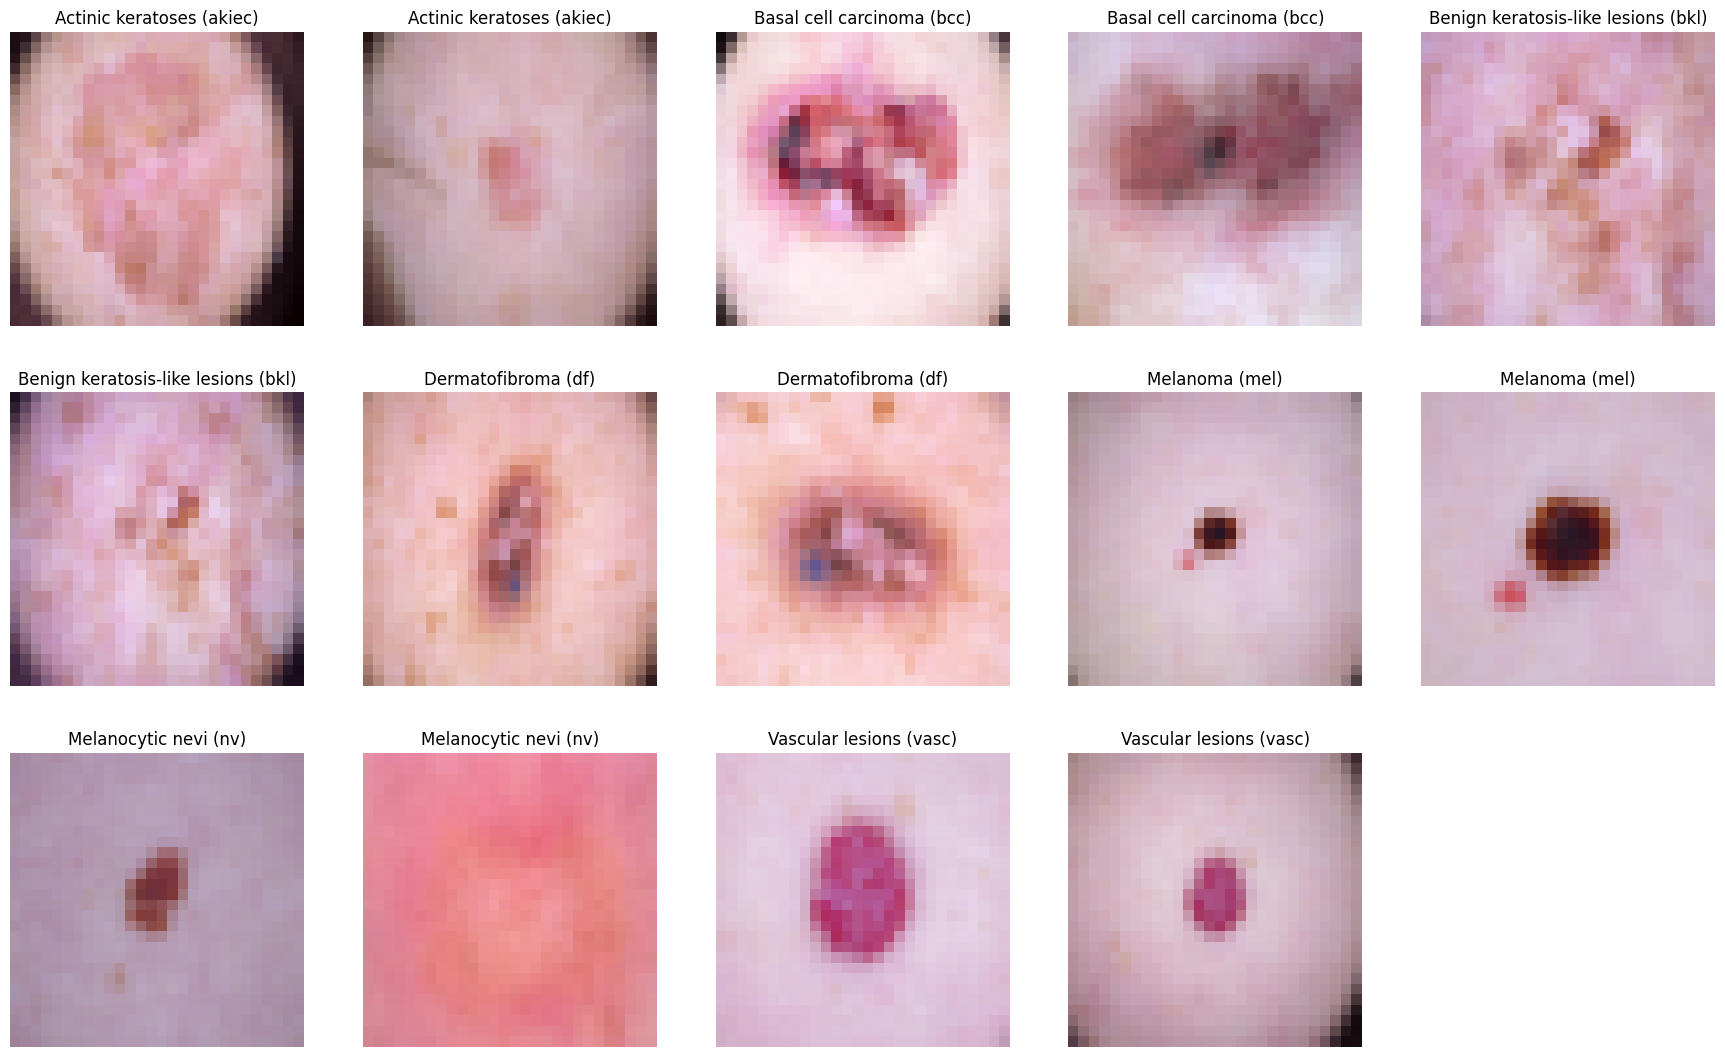

In [6]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()


5. Preprocessing

In [7]:
data.info()

# Checking null values
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   cell_type     10015 non-null  object 
 8   path          10015 non-null  object 
 9   image_pixel   10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.6+ KB


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
cell_type        0
path             0
image_pixel      0
dtype: int64

In [8]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')
# Categorically encoding label of the images 
data['label'] = data['dx'].map(reverse_label_mapping.get)
data.sample(5)

C:\Users\Ziven\AppData\Local\Temp\ipykernel_8796\806499239.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
9138,HAM_0003710,ISIC_0032074,nv,histo,60,male,abdomen,Melanocytic nevi (nv),C:/Users/Ziven/Downloads/archive\HAM10000_imag...,"[[[203, 177, 179], [208, 184, 185], [212, 188,...",0
696,HAM_0003183,ISIC_0027017,bkl,histo,75,male,neck,Benign keratosis-like lesions (bkl),C:/Users/Ziven/Downloads/archive\HAM10000_imag...,"[[[128, 88, 84], [133, 91, 87], [141, 102, 98]...",2
3237,HAM_0004006,ISIC_0031653,nv,follow_up,55,male,lower extremity,Melanocytic nevi (nv),C:/Users/Ziven/Downloads/archive\HAM10000_imag...,"[[[222, 141, 138], [223, 142, 138], [224, 141,...",0
3863,HAM_0004271,ISIC_0025474,nv,follow_up,55,female,trunk,Melanocytic nevi (nv),C:/Users/Ziven/Downloads/archive\HAM10000_imag...,"[[[236, 142, 143], [237, 144, 146], [238, 144,...",0
9340,HAM_0006551,ISIC_0030336,nv,consensus,25,male,lower extremity,Melanocytic nevi (nv),C:/Users/Ziven/Downloads/archive\HAM10000_imag...,"[[[172, 121, 138], [173, 123, 142], [174, 124,...",0


6. Data Augmentation

In [19]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Sort data by 'label' and reset index
data = data.sort_values('label').reset_index(drop=True)

# Group indexes based on labels
label_groups = {label: data[data['label'] == label] for label in range(1, 7)}

# Augmentation Factors
augmentation_factors = {1: 4, 2: 4, 3: 11, 4: 17, 5: 45, 6: 52}

# Perform augmentation for each label group
augmented_dataframes = [
    pd.concat([df] * (factor + 1), ignore_index=True)
    for label, factor in augmentation_factors.items()
    for df in [label_groups[label]]
]

# Concatenate all augmented dataframes with original data
final_data = pd.concat([data] + augmented_dataframes, ignore_index=True)

# Print dataset shapes
print(f"Original Data Shape: {data.shape}")
print(f"Augmented Data Shape: {final_data.shape}")

# Visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Sex', 'Localization', 'Age', 'Skin Type'],
    vertical_spacing=0.15,
    column_widths=[0.4, 0.6]
)

# Add traces for visualization
fig.add_trace(
    go.Bar(
        x=final_data['sex'].value_counts().index,
        y=final_data['sex'].value_counts()
    ), row=1, col=1
)
fig.add_trace(
    go.Bar(
        x=final_data['localization'].value_counts().index,
        y=final_data['localization'].value_counts()
    ), row=1, col=2
)
fig.add_trace(
    go.Histogram(
        x=final_data['age']
    ), row=2, col=1
)
fig.add_trace(
    go.Bar(
        x=final_data['dx'].value_counts().index.map(lesion_type_dict.get),
        y=final_data['dx'].value_counts()
    ), row=2, col=2
)

# Update layout and y-axis titles
for i in range(4):
    fig.update_yaxes(title_text='Count', row=i // 2 + 1, col=i % 2 + 1)

fig.update_layout(title='Distribution of Data After Augmentation', height=800)

# Display plot
fig.show()

# Clean up any additional level indices from the dataframe
if 'level_0' in data.columns:
    data = data.drop(columns=['level_0'])

data = data.reset_index(drop=True)

print("Data processing and visualization completed successfully!")


Original Data Shape: (10015, 13)
Augmented Data Shape: (45756, 13)


Data processing and visualization completed successfully!


Creating 2 sets of data for Model Training and Testing

In [20]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)
(10015, 28, 28, 3)
(10015, 1)

# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)
(45756, 28, 28, 3)
(45756, 1)

(10015, 28, 28, 3)
(10015, 1)
(45756, 28, 28, 3)
(45756, 1)


(45756, 1)

7. Model Creation, Training, and Testing

For Original Data:


In [21]:
%%time
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
#     tf.keras.utils.plot_model(model, to_file="model.png")
    return model;

def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history
    
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()
    
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)
model1 = create_model()


c:\Users\Ziven\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,583 (517.90 KB)

 Trainable params: 132,583 (517.90 KB)

 Non-trainable params: 0 (0.00 B)

None
CPU times: total: 156 ms
Wall time: 859 ms


In [22]:
model1_history = train_model(model1, X_train_orig, Y_train_orig, 50)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5610 - loss: 4.7786 - val_accuracy: 0.6332 - val_loss: 1.0077 - learning_rate: 0.0010
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6516 - loss: 0.9793 - val_accuracy: 0.6868 - val_loss: 0.8805 - learning_rate: 0.0010
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6920 - loss: 0.8619 - val_accuracy: 0.6956 - val_loss: 0.8582 - learning_rate: 0.0010
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7102 - loss: 0.8172 - val_accuracy: 0.7074 - val_loss: 0.8132 - learning_rate: 0.0010
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7274 - loss: 0.7704 - val_accuracy: 0.6825 - val_loss: 0.8206 - learning_rate: 0.0010
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7197 - loss: 0.7726 - val_accuracy: 0.7124 - val_loss: 0.7829 - learning_rate: 0.0010
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7508 - loss: 0.

For Augmented Dataset:


In [23]:
# For Augmented Dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)
model2 = create_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,583 (517.90 KB)

 Trainable params: 132,583 (517.90 KB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
model2_history = train_model(model2, X_train_aug, Y_train_aug, 50)


Epoch 1/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.3400 - loss: 2.1381 - val_accuracy: 0.5781 - val_loss: 1.0663 - learning_rate: 0.0010
Epoch 2/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6464 - loss: 0.9409 - val_accuracy: 0.7616 - val_loss: 0.6371 - learning_rate: 0.0010
Epoch 3/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7774 - loss: 0.5975 - val_accuracy: 0.8437 - val_loss: 0.4297 - learning_rate: 0.0010
Epoch 4/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8560 - loss: 0.3987 - val_accuracy: 0.8854 - val_loss: 0.3233 - learning_rate: 0.0010
Epoch 5/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8929 - loss: 0.3007 - val_accuracy: 0.9156 - val_loss: 0.2335 - learning_rate: 0.0010
Epoch 6/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9235 - loss: 0.2104 - val_accuracy: 0.9355 - val_loss: 0.1915 - learning_rate: 0.0010
Epoch 7/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9299 - loss: 0

8. Evaluation and Testing of Models

Test Accuracy: 74.338%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

          nv       0.87      0.89      0.88      1374
         mel       0.42      0.38      0.40       205
         bkl       0.46      0.44      0.45       227
         bcc       0.46      0.66      0.54        94
       akiec       0.36      0.22      0.27        55
        vasc       0.59      0.71      0.65        28
          df       0.00      0.00      0.00        20

    accuracy                           0.74      2003
   macro avg       0.45      0.47      0.46      2003
weighted avg       0.73      0.74      0.74      2003



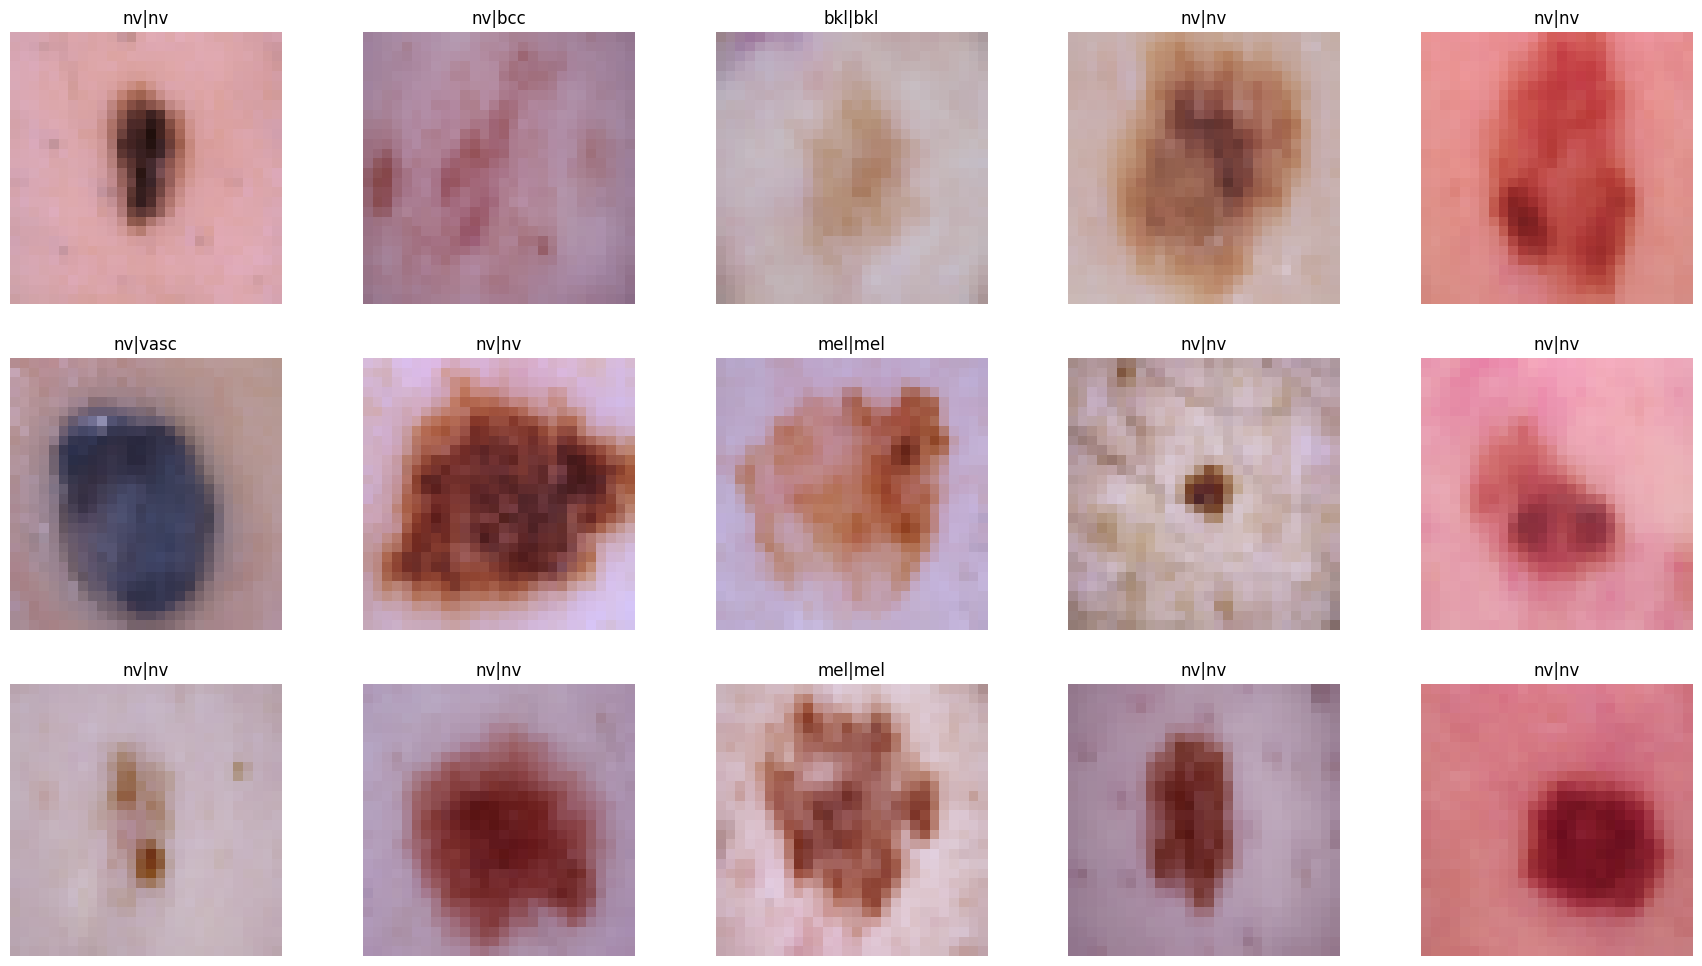

In [32]:
#For Original Dataset:
test_model(model1, X_test_orig, Y_test_orig)


Test Accuracy: 97.847%
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

          nv       0.98      0.87      0.92      1385
         mel       0.94      0.99      0.96      1328
         bkl       0.96      1.00      0.98      1294
         bcc       0.98      1.00      0.99      1325
       akiec       1.00      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



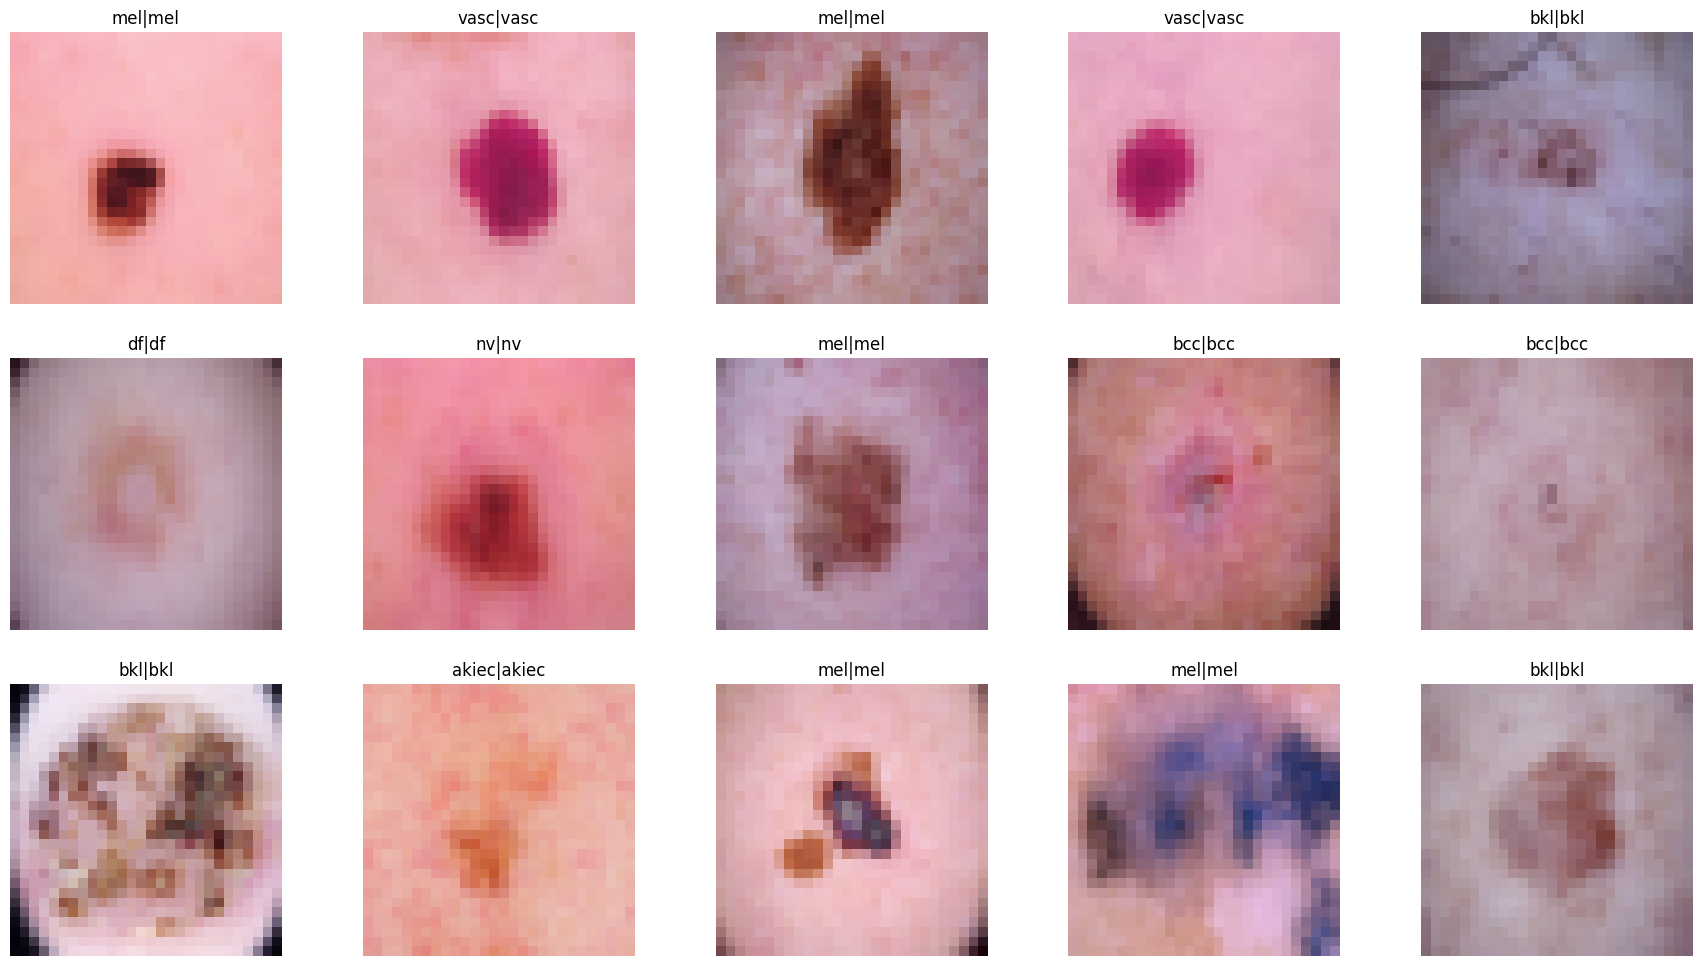

In [33]:
#For Augmented Dataset:

test_model(model2, X_test_aug, Y_test_aug)

9. Plotting Model Training Curve and Testing

In [39]:
#For Original Dataset:
plot_model_training_curve(model1_history)


For Augmented Dataset:

In [38]:
plot_model_training_curve(model2_history)

It emphasized the importance of early detection and how AI-powered models can assist dermatologists in accurate diagnosis. Additionally, leveraging CNNs for skin cancer detection 

[Blog](https://www.labellerr.com/blog/detecting-skin-cancer-using-convolutional-neural-networks-a-comprehensive-guide/?authuser=0)

i reffered this blog for better understanding of the consept nd understanding the dataset
